In [3]:
import os
import time
import string

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from tqdm import tqdm

# Font
from matplotlib import font_manager
font_path = "/workspace/fonts/"
font_list = os.listdir(font_path)
for font_file in font_list:
    try:
        font_manager.fontManager.addfont(font_path + font_file)
    except:
        raise Exception(f"Cannot Load {font_path+font_file}")

In [4]:
path = 'Data/'
flist = sorted([x for x in os.listdir('./Data/')if x.endswith('txt')])

df_oris = []
for f in tqdm(flist):
    df_ori = pd.read_csv(path+f, sep='\t', header=None)
    df_oris.append(df_ori)

df_ress = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}.parquet')
    df_ress.append(df_res)


df_ress2 = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}_EEMD.parquet')
    df_ress2.append(df_res)

100%|██████████| 21/21 [00:00<00:00, 734.85it/s]


In [5]:
df_tot = pd.DataFrame([], index=pd.date_range('1960-01-01', '2020-12-01', freq='MS', ))
# for idx in df_tot.index:
#     idx.day = 1
names = []
for i, df_ori in enumerate(df_oris):
    name = flist[i][8:-4]
    names.append(name)
    
    # 첫 번째 열을 datetime 형식으로 변환
    df_ori[0] = pd.to_datetime(df_ori[0].values, format='%Y %m %d %H %M')
    # 시간을 제거하고 일자를 1일로 설정
    t = df_ori[0].dt.to_period('M').dt.to_timestamp() + pd.offsets.MonthBegin(0)
    d = df_ori[1].values
    x = pd.Series(d, t)
    df_tot[name] = x
df_tot = df_tot.dropna(how='all')

In [6]:
import geopandas as gpd

df_geo = gpd.read_file('/Data/Backup/Data/Geo/sido_20240213/ctp_rvn.shp', encoding='euc-kr')
geog = df_geo.to_crs(epsg=4326)

df = pd.read_csv('./Data_final/total_results.csv', index_col=0)
df

sorted_name = ['Incheon', 'Anheung', 'Boryeong', 'Gunsan', 'Wido', 'Mokpo', 'Heuksando', 'Chujado', 'Jeju', 'Seogwipo', 
               'Wando', 'Geomundo', 'Yeosu', 'Tongyeong', 'Gadeokdo', 'Busan', 'Ulsan', 'Pohang', 'Mukho', 'Sokcho', 'Ulleungdo']
dict_name_to_index = {}
for i, n in enumerate(sorted_name):
    dict_name_to_index[n] = i

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import geopandas as gpd
import pandas as pd
import numpy as np
import string
from shapely.geometry import Point
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


def to_naive_datetime_index(s: pd.Series) -> pd.Series:
    """Ensure DatetimeIndex is tz-naive (for consistent plotting)."""
    s = s.copy()
    if isinstance(s.index, pd.PeriodIndex):
        s.index = s.index.to_timestamp(how='start')
    else:
        s.index = pd.DatetimeIndex(s.index)
    if s.index.tz is not None:
        s.index = s.index.tz_convert('UTC').tz_localize(None)
    return s


def add_scalebar(ax, length=50000, label="50 km"):
    """Add scale bar to a map axis."""
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(
        ax.transData, length, label, "lower right",
        pad=3.4, sep=4, color="black", frameon=False,
        size_vertical=0.8, fontproperties=fontprops
    )
    ax.add_artist(scalebar)


def add_north_arrow(ax, x, y, size=50000, text="N"):
    """Add north arrow at given (x, y)."""
    ax.annotate("", xy=(x, y + size), xytext=(x, y),
                arrowprops=dict(arrowstyle="-|>", lw=1.5))
    ax.text(x, y + size * 1.1, text, ha="center",
            va="bottom", fontsize=10, weight="bold")


def plot_map(ax, geog_proj, df_gdf, df, dict_name_to_index):
    """Draw base map with stations, scalebar, north arrow, labels."""
    geog_proj.plot(ax=ax, color="lightgrey", alpha=1.0)
    # geog_proj.plot(ax=ax, color="mediumseagreen", alpha=1.0)
    ax.scatter(df_gdf.geometry.x, df_gdf.geometry.y,
               s=12, c="orangered", label="Stations")

    for i in range(df.shape[0]):
        name, lat, lon = df.iloc[i, [0, 1, 2]]
        x, y = gpd.GeoSeries([Point(lon, lat)], crs=4326).to_crs(5181).iloc[0].xy
        xi, yi = x[0], y[0]
        if dict_name_to_index[name] == 15:
            xi += 20000
        ax.text(xi, yi, dict_name_to_index[name],
                weight="bold", ha="center", va="bottom", fontsize=8)

    add_scalebar(ax)
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    add_north_arrow(ax, x=xmax - 0.05*(xmax-xmin),
                    y=ymin + 0.11*(ymax-ymin))

    ax.legend(loc="upper right", frameon=True,
              fontsize=8, title_fontsize=9)
    ax.grid(True, alpha=0.2, lw=0.5)
    ax.tick_params(bottom=False, left=False,
                   labelbottom=False, labelleft=False)

    ax.text(0.99, 0.056, "Projection: Korea 2000 / EPSG:5181",
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=7, alpha=0.8)
    ax.text(0.99, 0.02, "Data: KHOA tides, Base: (source of coastline/boundaries)",
            transform=ax.transAxes, ha="right", va="bottom",
            fontsize=7, alpha=0.8)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.6)

    plt.text(50000, 220000, "YELLOW\nSEA", weight="bold",
             ha="center", va="bottom", size=14,
             rotation=80, alpha=0.8)
    plt.text(380000, 8000, "SOUTH SEA", weight="bold",
             ha="center", va="bottom", size=14,
             rotation=20, alpha=0.8)
    plt.text(530000, 260000, "EAST\nSEA", weight="bold",
             ha="center", va="bottom", size=14,
             rotation=-80, alpha=0.8)


def plot_timeseries(ax, df_tot, sorted_name, dy=60):
    """Plot aligned multi-station time series."""
    ys = range(len(sorted_name))
    for i in ys:
        s = df_tot[sorted_name[i]]
        s = to_naive_datetime_index(s)
        x_mean = s.mean()
        y = (s - x_mean) + dy * (len(sorted_name) - i)

        ax.plot(s.index.to_pydatetime(), y.values,
                lw=0.3, color="royalblue")
        plt.hlines(dy*(len(sorted_name) - i),
                   xmin=s.index.min(), xmax=s.index.max(),
                   color="grey", alpha=0.3, zorder=1, lw=0.3)

    _ = plt.yticks((np.arange(len(sorted_name))+1)*dy,
                   [f"{x} ({i})" for i, x in enumerate(sorted_name)][::-1],
                   fontsize=8)
    plt.ylim([+.5*dy, (ys[-1]+1.5)*dy])

    x_start = pd.Timestamp("1960-01-01")
    x_end   = pd.Timestamp("2020-01-01")

    ticks = pd.date_range(x_start, x_end, freq="10YS-JAN")

    ax.xaxis.set_major_locator(mticker.FixedLocator(mdates.date2num(ticks.to_pydatetime())))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.minorticks_off()
    ax.set_xlim(x_start, x_end)
    ax.yaxis.grid(True, which="major", alpha=0.3, lw=0.3)
    ax.set_axisbelow(True)

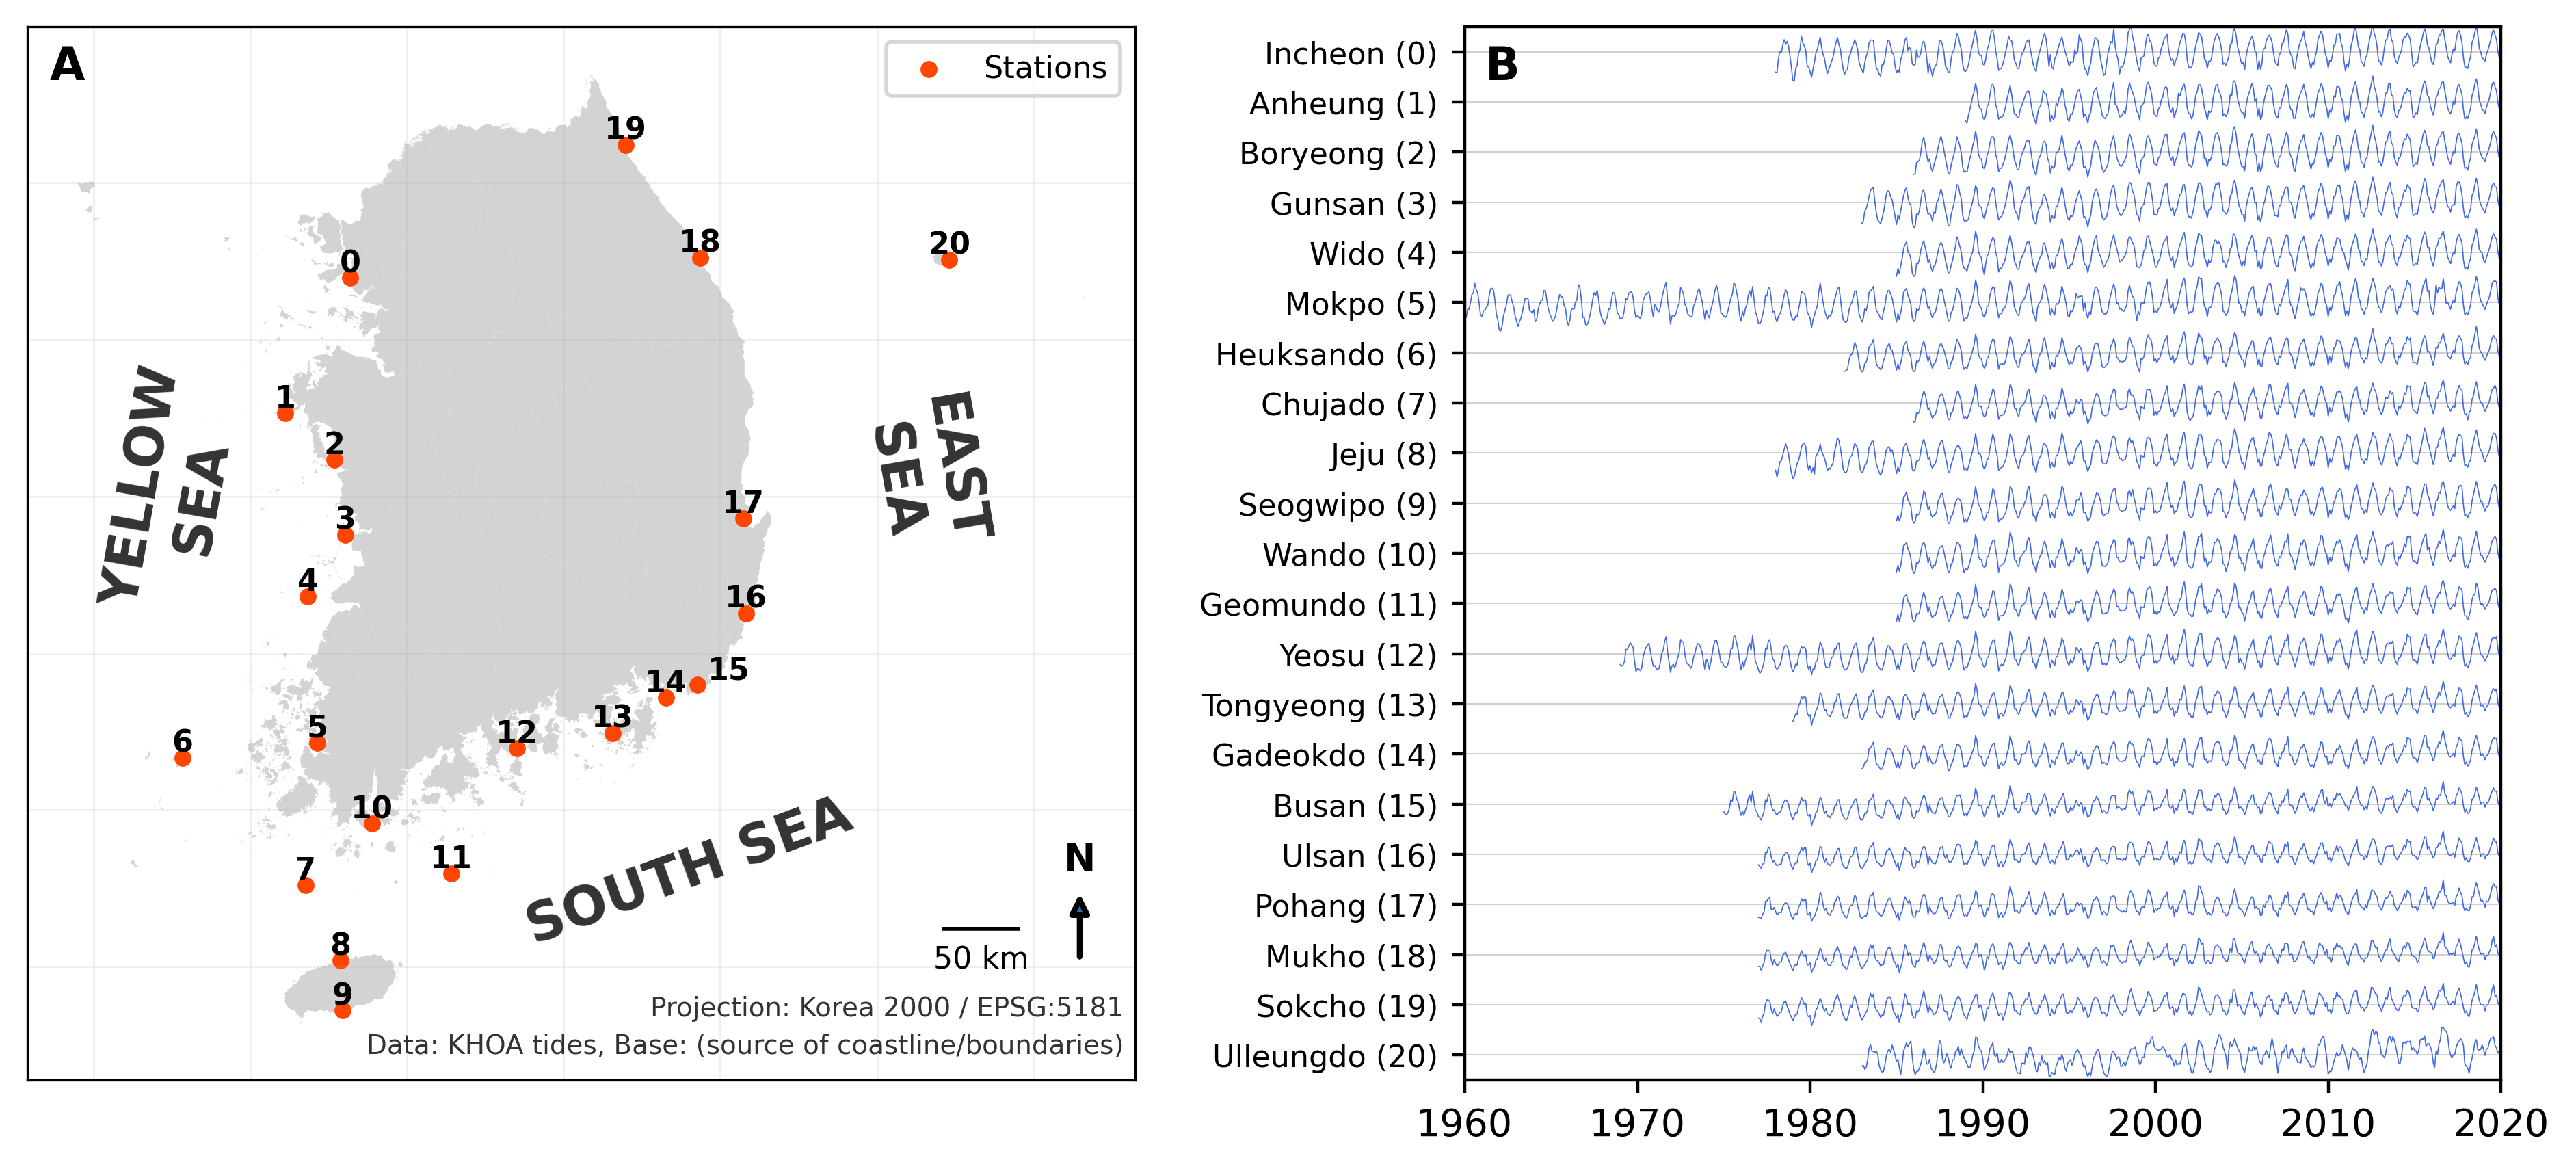

In [8]:
def main_plot(geog, df, dict_name_to_index, df_tot, sorted_name):
    """Generate full figure with map and time series."""
    fig = plt.figure(figsize=(20, 5), dpi=400)
    spec = gridspec.GridSpec(ncols=10, nrows=1, figure=fig, wspace=-.37)

    # Map subplot
    geog_proj = geog.to_crs(5181)
    df_gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=4326
    ).to_crs(5181)

    ax_map = fig.add_subplot(spec[0, :3])
    ax_map.text(.02, .95, "A", transform=ax_map.transAxes,
                size=12, weight="bold")
    plot_map(ax_map, geog_proj, df_gdf, df, dict_name_to_index)

    # Time series subplot
    ax_ts = fig.add_subplot(spec[0, 4:6])
    ax_ts.text(.02, .95, "B", transform=ax_ts.transAxes,
               size=12, weight="bold")
    plot_timeseries(ax_ts, df_tot, sorted_name)

    plt.savefig("Output/Figure1_Tidal_Gauge_Korea.pdf",
                format="pdf", dpi=400, bbox_inches="tight")


# 실행 예시
main_plot(geog, df, dict_name_to_index, df_tot, sorted_name)
